# Digits Conditional Modeling Study

This notebook studies how different conditional regression models learn to generate digit images conditioned on their labels.

**Problem Setup:**
- **Targets**: 8 PCA components of 64-pixel digit images
- **Conditioning**: 10-dimensional one-hot encoded digit labels (0-9)
- **Goal**: Learn p(pixels | digit_label) - generate realistic digit images given the label

**Models Compared:**
1. **ConditionalGMMRegressor**: Joint GMM over [X, y] with analytical conditioning
2. **MixtureOfExpertsRegressor**: Linear-softmax gating with Gaussian experts
3. **DiscriminativeConditionalGMMRegressor**: Discriminative EM for conditional likelihood

**Visualization**: For each model, we'll show a 9×5 grid where:
- Rows represent digits 0-9
- Columns show 5 random samples generated for each digit
- This allows us to assess the quality and diversity of generated digits


In [1]:
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')  # must be before pyplot import
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

from cgmm import ConditionalGMMRegressor, MixtureOfExpertsRegressor, DiscriminativeConditionalGMMRegressor

# Set random seed for reproducibility
np.random.seed(42)


## Data Preparation

Load the digits dataset and prepare it for conditional modeling:


In [2]:
n_pca = 20

# Load digits dataset
digits = load_digits()
X_original = digits.data  # (1797, 64) - original pixel values
y_labels = digits.target  # (1797,) - digit labels 0-9

print(f"Dataset shape: {X_original.shape}")
print(f"Labels: {np.unique(y_labels)}")
print(f"Label distribution: {np.bincount(y_labels)}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Apply PCA reduction to make the problem more manageable
pca = PCA(n_components=n_pca)
X_pca = pca.fit_transform(X_scaled)

print(f"\nPCA Results:")
print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.3f}")
print(f"  PCA components shape: {X_pca.shape}")

# Prepare conditioning variables (one-hot encoded digit labels)
encoder = OneHotEncoder(sparse_output=False)
X_conditioning = encoder.fit_transform(y_labels.reshape(-1, 1))  # (1797, 10)

# Set up the conditional modeling problem
y_target = X_pca  # (1797, 8) - PCA-reduced pixel values as targets
X_conditioning = X_conditioning  # (1797, 10) - one-hot digit labels as conditioning


Dataset shape: (1797, 64)
Labels: [0 1 2 3 4 5 6 7 8 9]
Label distribution: [178 182 177 183 181 182 181 179 174 180]

PCA Results:
  Explained variance ratio: 0.793
  PCA components shape: (1797, 20)


## Hyperparameter Optimization

Perform out-of-sample hyperparameter search by sweeping over n_components = 2..20 for all three models:


In [3]:
# Split data for hyperparameter optimization
X_train, X_test, y_train, y_test = train_test_split(
    X_conditioning, y_target, test_size=0.3, random_state=42
)

# Define hyperparameter search range (reduced for faster doc builds)
n_components_range = [2,3,4,5,7,10,15,20]

# Initialize results storage
hyperparameter_results = {
    'ConditionalGMMRegressor': {'n_components': [], 'log_likelihood': [], 'mse': [], 'r2': []},
    'MixtureOfExpertsRegressor': {'n_components': [], 'log_likelihood': [], 'mse': [], 'r2': []},
    'DiscriminativeConditionalGMMRegressor': {'n_components': [], 'log_likelihood': [], 'mse': [], 'r2': []}
}

# Cache best models during search to avoid retraining
best_models = {
    'ConditionalGMMRegressor': {'model': None, 'score': -np.inf},
    'MixtureOfExpertsRegressor': {'model': None, 'score': -np.inf},
    'DiscriminativeConditionalGMMRegressor': {'model': None, 'score': -np.inf}
}

for n_comp in n_components_range:
    

    model = ConditionalGMMRegressor(n_components=n_comp, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    log_likelihood = model.score(X_test, y_test)
    
    # Cache best model if this is the best score so far
    if log_likelihood > best_models['ConditionalGMMRegressor']['score']:
        best_models['ConditionalGMMRegressor']['model'] = model
        best_models['ConditionalGMMRegressor']['score'] = log_likelihood
    
    hyperparameter_results['ConditionalGMMRegressor']['n_components'].append(n_comp)
    hyperparameter_results['ConditionalGMMRegressor']['log_likelihood'].append(log_likelihood)
    hyperparameter_results['ConditionalGMMRegressor']['mse'].append(mse)
    hyperparameter_results['ConditionalGMMRegressor']['r2'].append(r2)
    
        

    model = MixtureOfExpertsRegressor(n_components=n_comp, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    log_likelihood = model.score(X_test, y_test)
    
    # Cache best model if this is the best score so far
    if log_likelihood > best_models['MixtureOfExpertsRegressor']['score']:
        best_models['MixtureOfExpertsRegressor']['model'] = model
        best_models['MixtureOfExpertsRegressor']['score'] = log_likelihood
    
    hyperparameter_results['MixtureOfExpertsRegressor']['n_components'].append(n_comp)
    hyperparameter_results['MixtureOfExpertsRegressor']['log_likelihood'].append(log_likelihood)
    hyperparameter_results['MixtureOfExpertsRegressor']['mse'].append(mse)
    hyperparameter_results['MixtureOfExpertsRegressor']['r2'].append(r2)
    

    model = DiscriminativeConditionalGMMRegressor(
        n_components=n_comp, 
        covariance_type='full',
        reg_covar=1e-2,
        random_state=42
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    log_likelihood = model.score(X_test, y_test)
    
    # Cache best model if this is the best score so far
    if log_likelihood > best_models['DiscriminativeConditionalGMMRegressor']['score']:
        best_models['DiscriminativeConditionalGMMRegressor']['model'] = model
        best_models['DiscriminativeConditionalGMMRegressor']['score'] = log_likelihood
    
    hyperparameter_results['DiscriminativeConditionalGMMRegressor']['n_components'].append(n_comp)
    hyperparameter_results['DiscriminativeConditionalGMMRegressor']['log_likelihood'].append(log_likelihood)
    hyperparameter_results['DiscriminativeConditionalGMMRegressor']['mse'].append(mse)
    hyperparameter_results['DiscriminativeConditionalGMMRegressor']['r2'].append(r2)
    


In [4]:
# Find optimal hyperparameters for each model
print("Optimal Hyperparameters (Out-of-Sample Performance):")
print("=" * 70)

optimal_params = {}

for model_name, results in hyperparameter_results.items():
    # Find the best log-likelihood (excluding NaN values)
    valid_mask = ~np.isnan(results['log_likelihood'])
    if valid_mask.any():
        valid_ll = np.array(results['log_likelihood'])[valid_mask]
        valid_components = np.array(results['n_components'])[valid_mask]
        valid_mse = np.array(results['mse'])[valid_mask]
        valid_r2 = np.array(results['r2'])[valid_mask]
        
        best_idx = np.argmax(valid_ll)
        best_components = valid_components[best_idx]
        best_ll = valid_ll[best_idx]
        best_mse = valid_mse[best_idx]
        best_r2 = valid_r2[best_idx]
        
        optimal_params[model_name] = {
            'n_components': best_components,
            'log_likelihood': best_ll,
            'mse': best_mse,
            'r2': best_r2
        }
        
        print(f"{model_name}:")
        print(f"  Optimal n_components: {best_components}")
        print(f"  Best log-likelihood: {best_ll:.3f}")
        print(f"  Best MSE: {best_mse:.3f}")
        print(f"  Best R²: {best_r2:.3f}")
        print()
    else:
        print(f"{model_name}: No valid results")
        print()

print("=" * 70)


Optimal Hyperparameters (Out-of-Sample Performance):
ConditionalGMMRegressor:
  Optimal n_components: 7
  Best log-likelihood: -21.097
  Best MSE: 1.302
  Best R²: 0.247

MixtureOfExpertsRegressor:
  Optimal n_components: 7
  Best log-likelihood: -18.816
  Best MSE: 1.833
  Best R²: -0.053

DiscriminativeConditionalGMMRegressor:
  Optimal n_components: 15
  Best log-likelihood: -18.123
  Best MSE: 1.316
  Best R²: 0.227



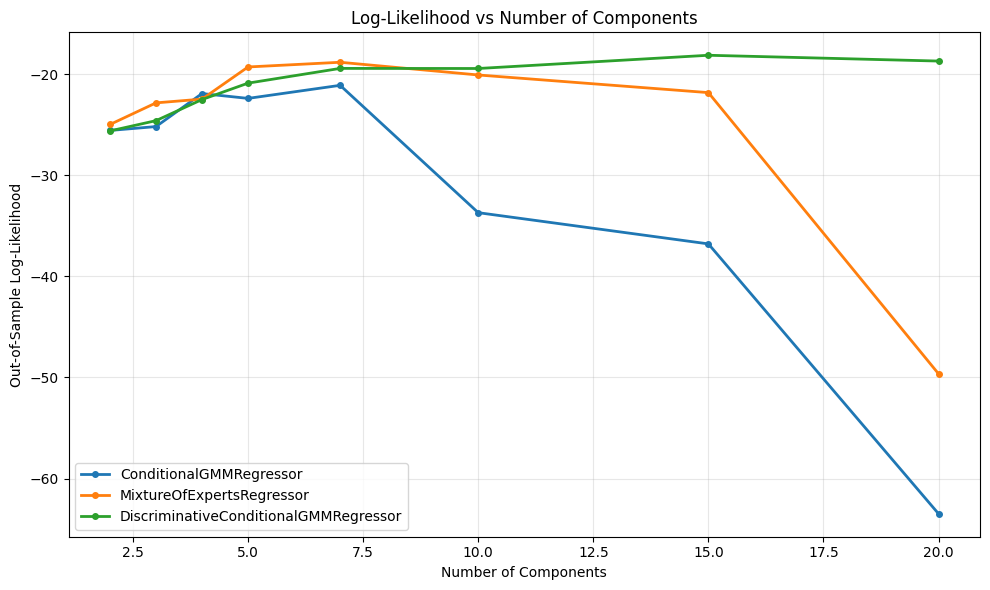

<Figure size 640x480 with 0 Axes>

In [5]:
# Create visualization plots for hyperparameter sweep results
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot 1: Log-likelihood vs n_components
ax1 = ax
for model_name, results in hyperparameter_results.items():
    valid_mask = ~np.isnan(results['log_likelihood'])
    if valid_mask.any():
        ax1.plot(results['n_components'], results['log_likelihood'], 
                'o-', label=model_name, linewidth=2, markersize=4)
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Out-of-Sample Log-Likelihood')
ax1.set_title('Log-Likelihood vs Number of Components')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('hyperparameter_sweep_results.png', dpi=150, bbox_inches='tight')


## Digit Generation and Visualization

Generate random samples for each digit (0-9) using each model and visualize them in a 10×5 grid:


In [6]:
def generate_digit_samples(model, digit_label, n_samples=5):
    """Generate n_samples for a specific digit using the trained model."""
    # Create one-hot encoding for the digit
    one_hot = np.zeros(10)
    one_hot[digit_label] = 1.0
    
    # Generate samples using the model's built-in sample() method
    X_conditioning = one_hot.reshape(1, -1)  # (1, 10)
    
    # Use the model's sample() method to generate samples
    samples = model.sample(X_conditioning, n_samples=n_samples)
    
    return samples  # (n_samples, 8)

def reconstruct_image(pca_components, pca, scaler):
    """Reconstruct image from PCA components back to original pixel space."""
    # Inverse PCA transform
    X_reconstructed = pca.inverse_transform(pca_components)  # (n_samples, 64)
    
    # Inverse scaling
    X_original_scale = scaler.inverse_transform(X_reconstructed)  # (n_samples, 64)
    
    # Clip to valid pixel range [0, 16]
    X_original_scale = np.clip(X_original_scale, 0, 16)
    
    return X_original_scale



In [18]:
# Generate samples using the best models from hyperparameter search
n_samples_per_digit = 8
digits_to_show = list(range(10))  # 0-9

print(f"Generating {n_samples_per_digit} samples for each digit (0-9) using best models...")

# Store generated samples for each model
generated_samples = {}
model_colors = {
    'ConditionalGMMRegressor': 'blue',
    'MixtureOfExpertsRegressor': 'green', 
    'DiscriminativeConditionalGMMRegressor': 'red'
}

for model_name in best_models.keys():
    if best_models[model_name]['model'] is not None:
        model = best_models[model_name]['model']
        print(f"  {model_name}: n_components = {model.n_components}")
        
        generated_samples[model_name] = {}
        
        for digit in digits_to_show:
            # Generate samples for this digit
            pca_samples = generate_digit_samples(model, digit, n_samples_per_digit)
            
            # Reconstruct to original image space
            image_samples = reconstruct_image(pca_samples, pca, scaler)
            
            generated_samples[model_name][digit] = image_samples
    else:
        print(f"  {model_name}: No valid model found")
        generated_samples[model_name] = None

print()
        


Generating 8 samples for each digit (0-9) using best models...
  ConditionalGMMRegressor: n_components = 7
  MixtureOfExpertsRegressor: n_components = 7
  DiscriminativeConditionalGMMRegressor: n_components = 15



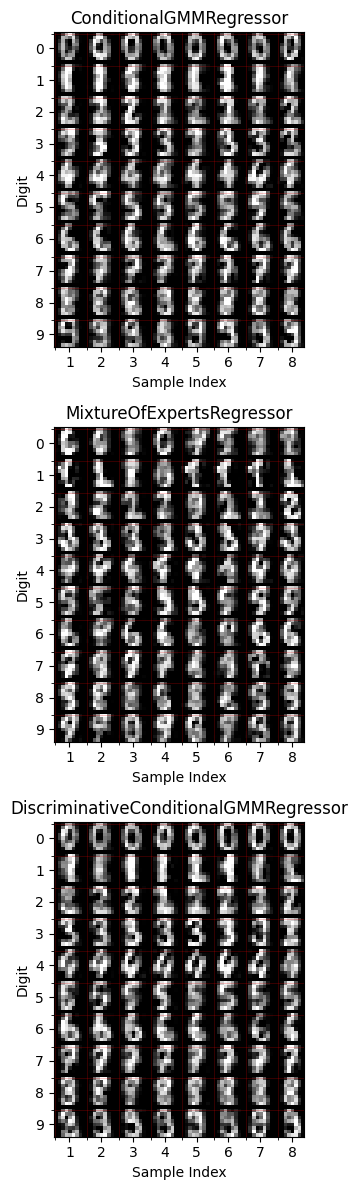

In [24]:
# Create visualization grids for each model
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

model_names = list(best_models.keys())
for model_idx, model_name in enumerate(model_names):
    if generated_samples[model_name] is None:
        continue
        
    ax = axes[model_idx]
    
    # Create a 10x8 grid with 1 pixel spacing between 8x8 images
    # Grid size: 10 rows * (8 pixels + 1 spacing) - 1, 8 cols * (8 pixels + 1 spacing) - 1
    grid = np.zeros((10 * 9 - 1, n_samples_per_digit * 9 - 1))  # 89x71 pixels
    
    for digit in range(10):
        if digit in generated_samples[model_name]:
            samples = generated_samples[model_name][digit]
            for sample_idx in range(min(n_samples_per_digit, len(samples))):
                # Reshape to 8x8 image
                image = samples[sample_idx].reshape(8, 8)
                
                # Place in grid with 1 pixel spacing
                row_start = digit * 9  # 8 pixels + 1 spacing
                col_start = sample_idx * 9  # 8 pixels + 1 spacing
                grid[row_start:row_start+8, col_start:col_start+8] = image
    
    # Display the grid
    im = ax.imshow(grid, cmap='gray', vmin=0, vmax=16)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Digit')
    
    # Set ticks (adjusted for 1 pixel spacing)
    ax.set_xticks(range(4, n_samples_per_digit*9, 9))  # Center of each 8x8 image with spacing
    ax.set_xticklabels(range(1, n_samples_per_digit + 1))
    ax.set_yticks(range(4, 10*9, 9))  # Center of each 8x8 image with spacing
    ax.set_yticklabels(range(10))
    
    # Add grid lines
    ax.set_xticks(range(0, n_samples_per_digit*9, 9), minor=True)
    ax.set_yticks(range(0, 10*9, 9), minor=True)
    ax.grid(True, which='minor', color='red', linewidth=0.5, alpha=0.3)

plt.tight_layout()
plt.show()


## Gallery Image

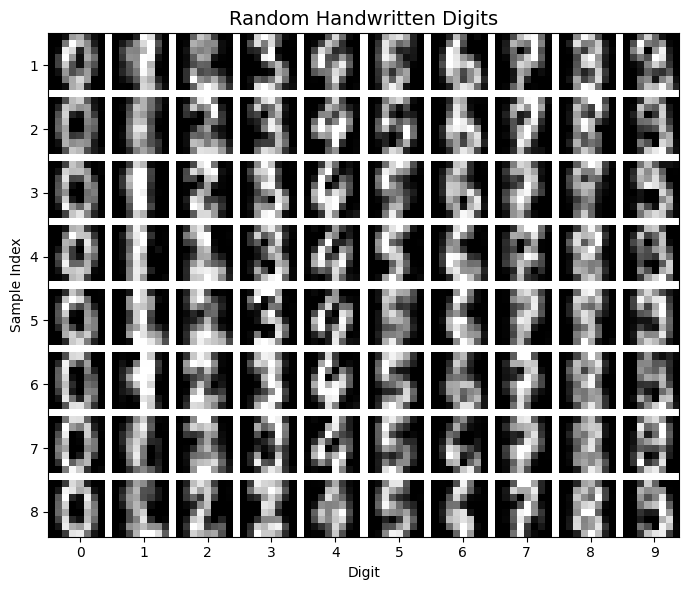

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

model_name = 'DiscriminativeConditionalGMMRegressor'

# Create a 8x10 grid with 1 pixel spacing between 8x8 images (transposed)
# Grid size: 8 rows * (8 pixels + 1 spacing) - 1, 10 cols * (8 pixels + 1 spacing) - 1
grid = np.zeros((n_samples_per_digit * 9 - 1, 10 * 9 - 1))  # 71x89 pixels

# Fill grid with white background (16 is max pixel value, so 16 = white)
grid.fill(16)

for digit in range(10):
    if digit in generated_samples[model_name]:
        samples = generated_samples[model_name][digit]
        for sample_idx in range(min(n_samples_per_digit, len(samples))):
            # Reshape to 8x8 image
            image = samples[sample_idx].reshape(8, 8)
            
            # Place in grid with 1 pixel spacing (transposed)
            row_start = sample_idx * 9  # 8 pixels + 1 spacing
            col_start = digit * 9  # 8 pixels + 1 spacing
            grid[row_start:row_start+8, col_start:col_start+8] = image

# Display the grid
im = ax.imshow(grid, cmap='gray', vmin=0, vmax=16)
ax.set_title('Random Handwritten Digits', fontsize=14)
ax.set_xlabel('Digit')
ax.set_ylabel('Sample Index')

# Set ticks (adjusted for 1 pixel spacing)
ax.set_xticks(range(4, 10*9, 9))  # Center of each 8x8 image with spacing
ax.set_xticklabels(range(10))
ax.set_yticks(range(4, n_samples_per_digit*9, 9))  # Center of each 8x8 image with spacing
ax.set_yticklabels(range(1, n_samples_per_digit + 1))

# No grid lines needed - white padding already provides separation

plt.tight_layout()
plt.savefig('gallery_images/digits.png', dpi=150, bbox_inches='tight')

plt.show()
